# 03. Confounded Datasets Exploration

**Pipeline Stage:** Generated Confounded Datasets (OSRCT Output)

**Objective:** Assess the generated confounded observational datasets, verify confounding was introduced correctly, and evaluate dataset quality across the experimental grid.

**Data Source:** `confounded_datasets/` directory

---

## Contents
1. Dataset Inventory
2. Generation Summary Analysis
3. Sample Dataset Deep Dive
4. Confounding Verification
5. Cross-Dataset Comparisons
6. Data Quality Assessment
7. Gaps and Sparse Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.3f}'.format)

# Paths
CONFOUNDED_DIR = Path('../confounded_datasets')
GROUND_TRUTH_PATH = CONFOUNDED_DIR / 'ground_truth_ates.csv'
GENERATION_SUMMARY_PATH = CONFOUNDED_DIR / 'generation_summary.csv'

---
## 1. Dataset Inventory

In [2]:
# Scan confounded datasets directory
print("DATASET INVENTORY")
print("=" * 60)

# Count datasets by study
studies = [d for d in CONFOUNDED_DIR.iterdir() if d.is_dir() and d.name not in ['metadata', 'site_stratified']]

inventory = []
total_files = 0
total_size = 0

for study_dir in sorted(studies):
    csv_files = list(study_dir.glob('*.csv'))
    n_files = len(csv_files)
    size_mb = sum(f.stat().st_size for f in csv_files) / 1e6
    
    # Parse patterns and betas
    patterns = set()
    betas = set()
    for f in csv_files:
        parts = f.stem.split('_')
        beta_idx = next((i for i, p in enumerate(parts) if p.startswith('beta')), None)
        if beta_idx:
            patterns.add('_'.join(parts[:beta_idx]))
            betas.add(float(parts[beta_idx].replace('beta', '')))
    
    inventory.append({
        'study': study_dir.name,
        'n_datasets': n_files,
        'size_mb': size_mb,
        'patterns': sorted(patterns),
        'n_patterns': len(patterns),
        'betas': sorted(betas),
        'n_betas': len(betas)
    })
    
    total_files += n_files
    total_size += size_mb

inventory_df = pd.DataFrame(inventory)
print(f"Total studies: {len(studies)}")
print(f"Total datasets: {total_files}")
print(f"Total size: {total_size:.1f} MB")
print(f"\n{inventory_df[['study', 'n_datasets', 'size_mb', 'n_patterns', 'n_betas']].to_string(index=False)}")

DATASET INVENTORY
Total studies: 15
Total datasets: 525
Total size: 612.9 MB

           study  n_datasets  size_mb  n_patterns  n_betas
allowedforbidden          35   41.199           5        7
      anchoring1          35   36.529           5        7
      anchoring2          35   36.293           5        7
      anchoring3          35   38.529           5        7
      anchoring4          35   38.512           5        7
         contact          35   42.141           5        7
            flag          35   41.174           5        7
        gainloss          35   42.756           5        7
         gambfal          35   41.340           5        7
             iat          35   47.685           5        7
           money          35   41.866           5        7
           quote          35   41.726           5        7
     reciprocity          35   42.072           5        7
          scales          35   39.985           5        7
            sunk          35   41.124

In [3]:
# Expected vs actual datasets
expected_per_study = 5 * 7  # 5 patterns × 7 betas = 35
expected_total = expected_per_study * 15  # 15 studies

print("\nEXPERIMENTAL GRID COVERAGE")
print("=" * 60)
print(f"Expected datasets per study: {expected_per_study}")
print(f"Expected total: {expected_total}")
print(f"Actual total: {total_files}")
print(f"Coverage: {total_files/expected_total*100:.1f}%")

# Studies with missing datasets
incomplete = inventory_df[inventory_df['n_datasets'] < expected_per_study]
if len(incomplete) > 0:
    print(f"\nStudies with incomplete coverage:")
    print(incomplete[['study', 'n_datasets']].to_string(index=False))


EXPERIMENTAL GRID COVERAGE
Expected datasets per study: 35
Expected total: 525
Actual total: 525
Coverage: 100.0%


---
## 2. Generation Summary Analysis

In [4]:
# Load generation summary
if GENERATION_SUMMARY_PATH.exists():
    gen_summary = pd.read_csv(GENERATION_SUMMARY_PATH)
    
    print("GENERATION SUMMARY")
    print("=" * 60)
    print(f"Records: {len(gen_summary)}")
    print(f"Successful: {gen_summary['success'].sum()}")
    print(f"Failed: {(~gen_summary['success']).sum()}")
    
    print(f"\nColumns: {list(gen_summary.columns)}")
else:
    print("Generation summary not found")
    gen_summary = None

GENERATION SUMMARY
Records: 630
Successful: 525
Failed: 105

Columns: ['rct_ate', 'rct_ate_se', 'obs_ate_naive', 'obs_ate_se', 'confounding_bias', 'sample_size_rct', 'sample_size_obs', 'sample_retention_rate', 'rct_treatment_rate', 'obs_treatment_rate', 'covariate_balance', 'study', 'beta', 'pattern', 'seed', 'covariates', 'coefficients', 'selection_prob_min', 'selection_prob_max', 'selection_prob_mean', 'selection_prob_std', 'output_file', 'success', 'error']


In [5]:
# Analyze generation results
if gen_summary is not None:
    # Success by pattern
    print("\nSUCCESS BY PATTERN")
    print(gen_summary.groupby('pattern')['success'].agg(['sum', 'count', 'mean']).round(3))
    
    # Success by beta
    print("\nSUCCESS BY BETA")
    print(gen_summary.groupby('beta')['success'].agg(['sum', 'count', 'mean']).round(3))
    
    # Failed generations
    failed = gen_summary[~gen_summary['success']]
    if len(failed) > 0:
        print(f"\nFAILED GENERATIONS ({len(failed)} total):")
        print(failed[['study', 'pattern', 'beta', 'error']].head(10))


SUCCESS BY PATTERN
            sum  count  mean
pattern                     
age         105    105 1.000
demo_basic  105    105 1.000
demo_full   105    105 1.000
gender      105    105 1.000
polideo     105    105 1.000
political     0    105 0.000

SUCCESS BY BETA
       sum  count  mean
beta                   
0.100   75     90 0.833
0.250   75     90 0.833
0.500   75     90 0.833
0.750   75     90 0.833
1.000   75     90 0.833
1.500   75     90 0.833
2.000   75     90 0.833

FAILED GENERATIONS (105 total):
         study    pattern  beta  \
35  anchoring1  political 0.100   
36  anchoring1  political 0.250   
37  anchoring1  political 0.500   
38  anchoring1  political 0.750   
39  anchoring1  political 1.000   
40  anchoring1  political 1.500   
41  anchoring1  political 2.000   
77  anchoring2  political 0.100   
78  anchoring2  political 0.250   
79  anchoring2  political 0.500   

                                                error  
35  ufunc 'isnan' not supported for the 

In [6]:
# Sample retention rates
if gen_summary is not None and 'sample_retention_rate' in gen_summary.columns:
    successful = gen_summary[gen_summary['success']]
    
    print("\nSAMPLE RETENTION RATES")
    print("=" * 60)
    print(f"Mean: {successful['sample_retention_rate'].mean():.3f}")
    print(f"Min: {successful['sample_retention_rate'].min():.3f}")
    print(f"Max: {successful['sample_retention_rate'].max():.3f}")
    
    # By beta
    print("\nRetention by beta:")
    print(successful.groupby('beta')['sample_retention_rate'].mean().round(3))


SAMPLE RETENTION RATES
Mean: 0.505
Min: 0.450
Max: 0.842

Retention by beta:
beta
0.100   0.501
0.250   0.502
0.500   0.504
0.750   0.506
1.000   0.507
1.500   0.508
2.000   0.509
Name: sample_retention_rate, dtype: float64


---
## 3. Sample Dataset Deep Dive

In [7]:
# Load a sample dataset
sample_study = 'anchoring1'
sample_pattern = 'age'
sample_beta = 0.5

sample_path = CONFOUNDED_DIR / sample_study / f'{sample_pattern}_beta{sample_beta}_seed42.csv'

if sample_path.exists():
    sample_df = pd.read_csv(sample_path)
    
    print(f"SAMPLE DATASET: {sample_study} / {sample_pattern} / beta={sample_beta}")
    print("=" * 60)
    print(f"Shape: {sample_df.shape}")
    print(f"\nColumns: {list(sample_df.columns)}")
    print(f"\nData types:")
    print(sample_df.dtypes)
else:
    print(f"Sample file not found: {sample_path}")
    # Try to find any dataset
    any_file = next(CONFOUNDED_DIR.rglob('*.csv'), None)
    if any_file:
        sample_df = pd.read_csv(any_file)
        print(f"Loaded alternative: {any_file.name}")

SAMPLE DATASET: anchoring1 / age / beta=0.5
Shape: (2632, 50)

Columns: ['id', 'date', 'site', 'resp_sex', 'resp_age', 'resp_race', 'resp_ethnicity', 'resp_citizenship', 'resp_major', 'resp_pid', 'resp_nativelang', 'resp_religion', 'resp_american', 'resp_american_pid', 'resp_american_ideo', 'exp_sex', 'exp_race', 'study_numparticipants', 'study_exprunafter', 'study_separated', 'study_recruit', 'study_compensation', 'study_online', 'study_country', 'study_usa', 'filter_iat', 'iv', 'dv', 'original_study', 'original_study_name', 'resp_gender', 'resp_ethnicity_hisp', 'RACE', 'RACE_american_indian', 'RACE_black_american', 'RACE_brazil', 'RACE_east_asian', 'RACE_more_than_one', 'RACE_nederland', 'RACE_others', 'RACE_south_asian', 'RACE_white', 'MAJOR', 'MAJOR_Engineer', 'MAJOR_Science', 'MAJOR_Social', 'MAJOR_others', 'resp_polideo', '_selection_prob', '_preferred_treatment']

Data types:
id                       float64
date                      object
site                      object
resp_

In [8]:
# Sample data overview
print("\nSAMPLE DATA OVERVIEW")
print("=" * 60)
print(sample_df.describe())


SAMPLE DATA OVERVIEW
               id  resp_age  resp_american  resp_american_pid  \
count    2632.000  2632.000       2632.000           2632.000   
mean  2435971.220    26.417          8.019              3.854   
std     86346.557    11.705          3.048              1.112   
min    619630.000    14.000          1.000              1.000   
25%   2409492.750    19.000          6.000              3.000   
50%   2432851.500    21.000          9.000              4.000   
75%   2472431.000    30.000         11.000              4.000   
max   2511223.000    78.000         11.000              7.000   

       resp_american_ideo  study_numparticipants  study_online  study_usa  \
count            2632.000               1149.000      2632.000   2632.000   
mean                3.888                  6.201         0.527      0.625   
std                 1.113                  5.551         0.499      0.484   
min                 1.000                  0.000         0.000      0.000   
25%    

In [9]:
# First rows
print("\nFIRST 10 ROWS")
sample_df.head(10)


FIRST 10 ROWS


,id,date,site,resp_sex,resp_age,resp_race,resp_ethnicity,resp_citizenship,resp_major,resp_pid,resp_nativelang,resp_religion,resp_american,resp_american_pid,resp_american_ideo,exp_sex,exp_race,study_numparticipants,study_exprunafter,study_separated,study_recruit,study_compensation,study_online,study_country,study_usa,filter_iat,iv,dv,original_study,original_study_name,resp_gender,resp_ethnicity_hisp,RACE,RACE_american_indian,RACE_black_american,RACE_brazil,RACE_east_asian,RACE_more_than_one,RACE_nederland,RACE_others,RACE_south_asian,RACE_white,MAJOR,MAJOR_Engineer,MAJOR_Science,MAJOR_Social,MAJOR_others,resp_polideo,_selection_prob,_preferred_treatment
0,2400860.000,2013-08-28 12:15:57,abington,female,18.000,white,not hispanic or latino,US,Visual and performing arts,Moderately Conservative,other,NaN,4.000,5.000,5.000,male,white,5.000,runalone,barriers,unisubjpool,coursecredit,0.000,USA,1,1.000,0.000,4676.000,anchoring1,"Anchoring (Jacowitz & Kahneman, 1995) - NYC",1.000,0.000,white,False,False,False,False,False,False,False,False,True,others,False,False,False,True,1.000,0.411,0
1,2400868.000,2013-08-28 12:12:21,abington,male,18.000,white,not hispanic or latino,US,Biological sciences/life sciences,Neutral (Moderate),english,NaN,8.000,4.000,4.000,male,white,5.000,runalone,barriers,unisubjpool,coursecredit,0.000,USA,1,1.000,1.000,2163.500,anchoring1,"Anchoring (Jacowitz & Kahneman, 1995) - NYC",0.000,0.000,white,False,False,False,False,False,False,False,False,True,Science,False,True,False,False,3.000,0.411,1
2,2400916.000,2013-08-28 12:19:14,abington,female,18.000,south asian,not hispanic or latino,US,"Engineering, mathematics, physical sciences/te...",Neutral (Moderate),english,NaN,11.000,4.000,4.000,male,white,5.000,runalone,nobarriers,unisubjpool,coursecredit,0.000,USA,1,1.000,1.000,2163.500,anchoring1,"Anchoring (Jacowitz & Kahneman, 1995) - NYC",1.000,0.000,south_asian,False,False,False,False,False,False,False,True,False,Engineer,True,False,False,False,3.000,0.411,1
3,2400925.000,2013-08-28 12:16:21,abington,male,19.000,east asian,NaN,US,Education,Neutral (Moderate),english,NaN,7.000,3.000,6.000,male,white,5.000,runalone,barriers,unisubjpool,coursecredit,0.000,USA,1,1.000,0.000,580.000,anchoring1,"Anchoring (Jacowitz & Kahneman, 1995) - NYC",0.000,0.170,east_asian,False,False,False,True,False,False,False,False,False,Social,False,False,True,False,3.000,0.421,0
4,2400934.000,2013-08-28 12:22:38,abington,male,21.000,black or african american,not hispanic or latino,US,Law or legal studies,Neutral (Moderate),english,NaN,5.000,1.000,7.000,male,white,9.000,runalone,nobarriers,unisubjpool,coursecredit,0.000,USA,1,1.000,0.000,2163.500,anchoring1,"Anchoring (Jacowitz & Kahneman, 1995) - NYC",0.000,0.000,black_american,False,True,False,False,False,False,False,False,False,Social,False,False,True,False,3.000,0.442,0
5,2407222.000,2013-09-03 11:13:58,abington,female,18.000,white,NaN,US,Agriculture and related sciences,NaN,other,NaN,8.000,3.000,2.000,male,white,3.000,runalone,barriers,unisubjpool,coursecredit,0.000,USA,1,1.000,0.000,2163.500,anchoring1,"Anchoring (Jacowitz & Kahneman, 1995) - NYC",1.000,0.170,white,False,False,False,False,False,False,False,False,True,others,False,False,False,True,3.377,0.411,0
6,2407335.000,2013-09-03 12:16:09,abington,female,23.000,more than one race - other,NaN,US,Law or legal studies,NaN,english,NaN,8.000,1.000,2.000,male,white,9.000,runalone,barriers,unisubjpool,coursecredit,0.000,USA,1,0.000,0.000,1189.000,anchoring1,"Anchoring (Jacowitz & Kahneman, 1995) - NYC",1.000,0.170,more_than_one,False,False,False,False,True,False,False,False,False,Social,False,False,True,False,3.377,0.464,0
7,2407367.000,2013-09-03 12:47:40,abington,female,18.000,white,NaN,US,Visual and performing arts,NaN,english,NaN,11.000,7.000,7.000,male,white,9.000,runalone,barriers,unisubjpool,coursecredit,0.000,USA,1,1.000,1.000,2163.500,anchoring1,"Anchoring (Jacowitz & Kahneman, 1995) - NYC",1.000,0.170,white,False,False,False,False,F

In [10]:
# Treatment/outcome summary
print("\nTREATMENT AND OUTCOME SUMMARY")
print("=" * 60)

if 'iv' in sample_df.columns:
    print(f"Treatment (iv):")
    print(f"  Total: {len(sample_df)}")
    print(f"  Treated: {(sample_df['iv']==1).sum()}")
    print(f"  Control: {(sample_df['iv']==0).sum()}")
    print(f"  Rate: {sample_df['iv'].mean():.3f}")

if 'dv' in sample_df.columns:
    print(f"\nOutcome (dv):")
    treated_outcome = sample_df[sample_df['iv']==1]['dv']
    control_outcome = sample_df[sample_df['iv']==0]['dv']
    print(f"  Treated mean: {treated_outcome.mean():.3f}")
    print(f"  Control mean: {control_outcome.mean():.3f}")
    print(f"  Naive ATE: {treated_outcome.mean() - control_outcome.mean():.3f}")


TREATMENT AND OUTCOME SUMMARY
Treatment (iv):
  Total: 2632
  Treated: 1340
  Control: 1292
  Rate: 0.509

Outcome (dv):
  Treated mean: 3402.674
  Control mean: 1874.395
  Naive ATE: 1528.279


---
## 4. Confounding Verification

In [11]:
# Load ground truth for comparison
if GROUND_TRUTH_PATH.exists():
    ground_truth = pd.read_csv(GROUND_TRUTH_PATH)
    print("GROUND TRUTH ATES")
    print("=" * 60)
    print(ground_truth[['study', 'ate', 'ate_se']].to_string(index=False))
else:
    ground_truth = None
    print("Ground truth file not found")

GROUND TRUTH ATES
           study      ate  ate_se
allowedforbidden   -0.165   0.009
      anchoring1 1555.666  36.244
      anchoring2 2028.948  31.216
      anchoring3 2418.373  28.898
      anchoring4 2494.929  27.511
         contact    0.246   0.049
            flag    0.028   0.026
        gainloss    0.287   0.012
         gambfal    1.696   0.074
             iat    0.260   0.014
           money   -0.020   0.025
           quote    0.695   0.054
     reciprocity    0.134   0.011
          scales    0.175   0.009
            sunk    0.606   0.056


In [12]:
# Verify confounding was introduced
def check_confounding(df, covariate):
    """Check if covariate is imbalanced between treatment groups."""
    if covariate not in df.columns:
        return None
    
    treated = df[df['iv'] == 1][covariate].dropna()
    control = df[df['iv'] == 0][covariate].dropna()
    
    # Standardized mean difference
    pooled_std = np.sqrt((treated.var() + control.var()) / 2)
    smd = (treated.mean() - control.mean()) / pooled_std if pooled_std > 0 else 0
    
    return {
        'covariate': covariate,
        'treated_mean': treated.mean(),
        'control_mean': control.mean(),
        'smd': smd,
        'imbalanced': abs(smd) > 0.1
    }

print("\nCONFOUNDING VERIFICATION")
print("=" * 60)
print("(Checking if covariates are imbalanced - indicating confounding)\n")

covariates = ['resp_age', 'resp_gender', 'resp_polideo']
for cov in covariates:
    result = check_confounding(sample_df, cov)
    if result:
        status = 'IMBALANCED (confounded)' if result['imbalanced'] else 'balanced'
        print(f"{cov}:")
        print(f"  Treated mean: {result['treated_mean']:.3f}")
        print(f"  Control mean: {result['control_mean']:.3f}")
        print(f"  SMD: {result['smd']:.3f} -> {status}")
        print()


CONFOUNDING VERIFICATION
(Checking if covariates are imbalanced - indicating confounding)

resp_age:
  Treated mean: 28.807
  Control mean: 23.938
  SMD: 0.427 -> IMBALANCED (confounded)

resp_gender:
  Treated mean: 0.660
  Control mean: 0.666
  SMD: -0.013 -> balanced

resp_polideo:
  Treated mean: 3.525
  Control mean: 3.362
  SMD: 0.103 -> IMBALANCED (confounded)



In [13]:
# Compare naive ATE to ground truth
if ground_truth is not None and 'original_study' in sample_df.columns:
    study = sample_df['original_study'].iloc[0] if 'original_study' in sample_df.columns else sample_study
    true_ate = ground_truth[ground_truth['study'] == study]['ate'].values[0]
    
    treated = sample_df[sample_df['iv'] == 1]['dv']
    control = sample_df[sample_df['iv'] == 0]['dv']
    naive_ate = treated.mean() - control.mean()
    
    bias = naive_ate - true_ate
    
    print("\nBIAS VERIFICATION")
    print("=" * 60)
    print(f"Study: {study}")
    print(f"True ATE (from RCT): {true_ate:.3f}")
    print(f"Naive ATE (confounded): {naive_ate:.3f}")
    print(f"Confounding bias: {bias:.3f} ({bias/true_ate*100:.1f}%)")


BIAS VERIFICATION
Study: anchoring1
True ATE (from RCT): 1555.666
Naive ATE (confounded): 1528.279
Confounding bias: -27.387 (-1.8%)


---
## 5. Cross-Dataset Comparisons

In [14]:
# Compare across beta values for one study/pattern
def load_and_analyze(study, pattern, beta):
    """Load dataset and compute key statistics."""
    path = CONFOUNDED_DIR / study / f'{pattern}_beta{beta}_seed42.csv'
    if not path.exists():
        return None
    
    df = pd.read_csv(path)
    
    treated = df[df['iv'] == 1]['dv']
    control = df[df['iv'] == 0]['dv']
    naive_ate = treated.mean() - control.mean()
    
    # Covariate imbalance
    cov = 'resp_age' if pattern == 'age' else 'resp_gender' if pattern == 'gender' else 'resp_polideo'
    if cov in df.columns:
        t_cov = df[df['iv'] == 1][cov].mean()
        c_cov = df[df['iv'] == 0][cov].mean()
        pooled_std = np.sqrt((df[df['iv']==1][cov].var() + df[df['iv']==0][cov].var()) / 2)
        smd = (t_cov - c_cov) / pooled_std if pooled_std > 0 else 0
    else:
        smd = None
    
    return {
        'beta': beta,
        'n': len(df),
        'treatment_rate': df['iv'].mean(),
        'naive_ate': naive_ate,
        'cov_smd': smd
    }

# Analyze across betas
print("COMPARISON ACROSS CONFOUNDING STRENGTHS")
print("=" * 60)
print(f"Study: {sample_study}, Pattern: {sample_pattern}\n")

betas = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
beta_results = []
for beta in betas:
    result = load_and_analyze(sample_study, sample_pattern, beta)
    if result:
        beta_results.append(result)

if beta_results:
    beta_df = pd.DataFrame(beta_results)
    print(beta_df.to_string(index=False))

COMPARISON ACROSS CONFOUNDING STRENGTHS
Study: anchoring1, Pattern: age

 beta    n  treatment_rate  naive_ate  cov_smd
0.100 2673           0.510   1556.610    0.053
0.250 2668           0.512   1547.383    0.194
0.500 2632           0.509   1528.279    0.427
0.750 2650           0.500   1535.534    0.647
1.000 2653           0.495   1552.802    0.798
1.500 2666           0.471   1534.433    1.032
2.000 2656           0.451   1522.568    1.181


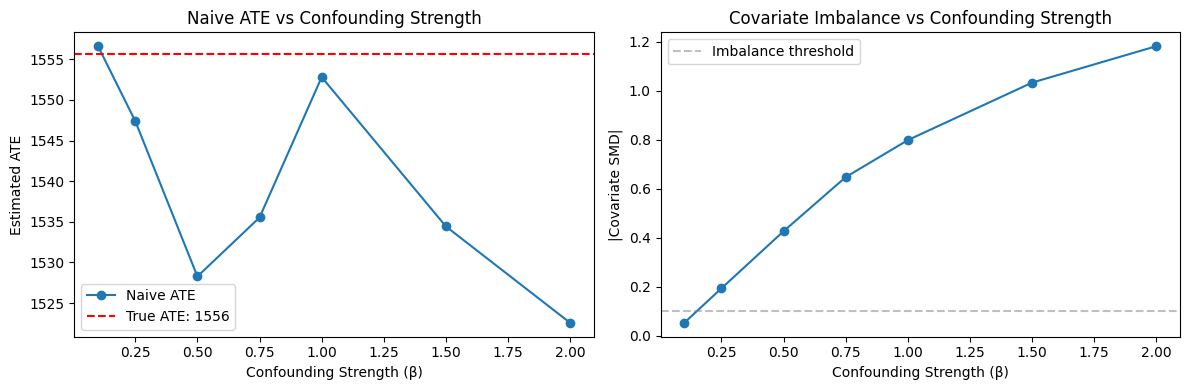

In [15]:
# Visualize beta effect
if beta_results and ground_truth is not None:
    true_ate = ground_truth[ground_truth['study'] == sample_study]['ate'].values[0]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Naive ATE vs beta
    axes[0].plot(beta_df['beta'], beta_df['naive_ate'], 'o-', label='Naive ATE')
    axes[0].axhline(y=true_ate, color='red', linestyle='--', label=f'True ATE: {true_ate:.0f}')
    axes[0].set_xlabel('Confounding Strength (β)')
    axes[0].set_ylabel('Estimated ATE')
    axes[0].set_title('Naive ATE vs Confounding Strength')
    axes[0].legend()
    
    # Covariate imbalance vs beta
    axes[1].plot(beta_df['beta'], beta_df['cov_smd'].abs(), 'o-')
    axes[1].axhline(y=0.1, color='gray', linestyle='--', alpha=0.5, label='Imbalance threshold')
    axes[1].set_xlabel('Confounding Strength (β)')
    axes[1].set_ylabel('|Covariate SMD|')
    axes[1].set_title('Covariate Imbalance vs Confounding Strength')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

---
## 6. Data Quality Assessment

In [16]:
# Comprehensive quality check across all datasets
print("COMPREHENSIVE DATA QUALITY CHECK")
print("=" * 60)

quality_issues = []
quality_stats = []

# Sample from each study
for study_dir in sorted(studies)[:5]:  # Check first 5 studies
    csv_files = list(study_dir.glob('*.csv'))[:3]  # Check 3 files per study
    
    for f in csv_files:
        try:
            df = pd.read_csv(f)
            
            # Quality checks
            n_rows = len(df)
            pct_missing = df.isnull().sum().sum() / df.size * 100
            treatment_rate = df['iv'].mean() if 'iv' in df.columns else None
            n_duplicates = df.duplicated().sum()
            
            quality_stats.append({
                'file': f.name,
                'study': study_dir.name,
                'n_rows': n_rows,
                'pct_missing': pct_missing,
                'treatment_rate': treatment_rate,
                'n_duplicates': n_duplicates
            })
            
            # Flag issues
            if n_rows < 100:
                quality_issues.append(f"{f.name}: Very small sample ({n_rows})")
            if pct_missing > 10:
                quality_issues.append(f"{f.name}: High missing data ({pct_missing:.1f}%)")
            if treatment_rate and (treatment_rate < 0.2 or treatment_rate > 0.8):
                quality_issues.append(f"{f.name}: Extreme treatment rate ({treatment_rate:.2f})")
            if n_duplicates > 0:
                quality_issues.append(f"{f.name}: {n_duplicates} duplicate rows")
                
        except Exception as e:
            quality_issues.append(f"{f.name}: Read error - {str(e)[:50]}")

quality_df = pd.DataFrame(quality_stats)
print(f"Checked {len(quality_stats)} files\n")
print(quality_df.describe().round(3))

COMPREHENSIVE DATA QUALITY CHECK
Checked 15 files

        n_rows  pct_missing  treatment_rate  n_duplicates
count   15.000       15.000          15.000        15.000
mean  2836.067       10.440           0.503         0.000
std    178.387        0.110           0.013         0.000
min   2636.000       10.327           0.485         0.000
25%   2724.000       10.365           0.492         0.000
50%   2807.000       10.414           0.502         0.000
75%   2836.000       10.446           0.513         0.000
max   3162.000       10.650           0.522         0.000


In [17]:
# Report quality issues
print("\nQUALITY ISSUES FOUND")
print("=" * 60)
if quality_issues:
    for issue in quality_issues[:20]:
        print(f"  - {issue}")
    if len(quality_issues) > 20:
        print(f"  ... and {len(quality_issues) - 20} more issues")
else:
    print("  No issues found in sampled files")


QUALITY ISSUES FOUND
  - demo_full_beta0.1_seed42.csv: High missing data (10.3%)
  - demo_full_beta0.25_seed42.csv: High missing data (10.4%)
  - demo_full_beta0.5_seed42.csv: High missing data (10.3%)
  - demo_full_beta0.1_seed42.csv: High missing data (10.4%)
  - demo_full_beta0.25_seed42.csv: High missing data (10.4%)
  - demo_full_beta0.5_seed42.csv: High missing data (10.4%)
  - demo_full_beta0.1_seed42.csv: High missing data (10.4%)
  - demo_full_beta0.25_seed42.csv: High missing data (10.4%)
  - demo_full_beta0.5_seed42.csv: High missing data (10.5%)
  - demo_full_beta0.1_seed42.csv: High missing data (10.4%)
  - demo_full_beta0.25_seed42.csv: High missing data (10.4%)
  - demo_full_beta0.5_seed42.csv: High missing data (10.4%)
  - demo_full_beta0.1_seed42.csv: High missing data (10.6%)
  - demo_full_beta0.25_seed42.csv: High missing data (10.6%)
  - demo_full_beta0.5_seed42.csv: High missing data (10.6%)


---
## 7. Gaps and Sparse Data Analysis

In [18]:
# Identify gaps in the experimental grid
print("EXPERIMENTAL GRID GAPS")
print("=" * 60)

expected_patterns = ['age', 'gender', 'polideo', 'demo_basic', 'demo_full']
expected_betas = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
expected_studies = [d.name for d in studies]

gaps = []
for study in expected_studies:
    for pattern in expected_patterns:
        for beta in expected_betas:
            expected_file = CONFOUNDED_DIR / study / f'{pattern}_beta{beta}_seed42.csv'
            if not expected_file.exists():
                gaps.append({'study': study, 'pattern': pattern, 'beta': beta})

if gaps:
    gaps_df = pd.DataFrame(gaps)
    print(f"\nMissing datasets: {len(gaps)}")
    print(f"\nGaps by pattern:")
    print(gaps_df.groupby('pattern').size())
    print(f"\nGaps by study:")
    print(gaps_df.groupby('study').size())
else:
    print("\nNo gaps found - full experimental grid coverage")

EXPERIMENTAL GRID GAPS

No gaps found - full experimental grid coverage


In [19]:
# Sample size distribution
print("\nSAMPLE SIZE DISTRIBUTION")
print("=" * 60)

sample_sizes = []
for study_dir in studies:
    for f in study_dir.glob('*.csv'):
        try:
            # Quick row count
            n_rows = sum(1 for _ in open(f)) - 1  # Subtract header
            sample_sizes.append({
                'study': study_dir.name,
                'file': f.name,
                'n_rows': n_rows
            })
        except:
            pass

sizes_df = pd.DataFrame(sample_sizes)
print(sizes_df['n_rows'].describe().round(0))

# Sparse datasets (< 500 rows)
sparse = sizes_df[sizes_df['n_rows'] < 500]
if len(sparse) > 0:
    print(f"\nSparse datasets (< 500 rows): {len(sparse)}")
    print(sparse.groupby('study').size())


SAMPLE SIZE DISTRIBUTION
count    525.000
mean    3029.000
std      248.000
min     2579.000
25%     2843.000
50%     3097.000
75%     3165.000
max     4917.000
Name: n_rows, dtype: float64


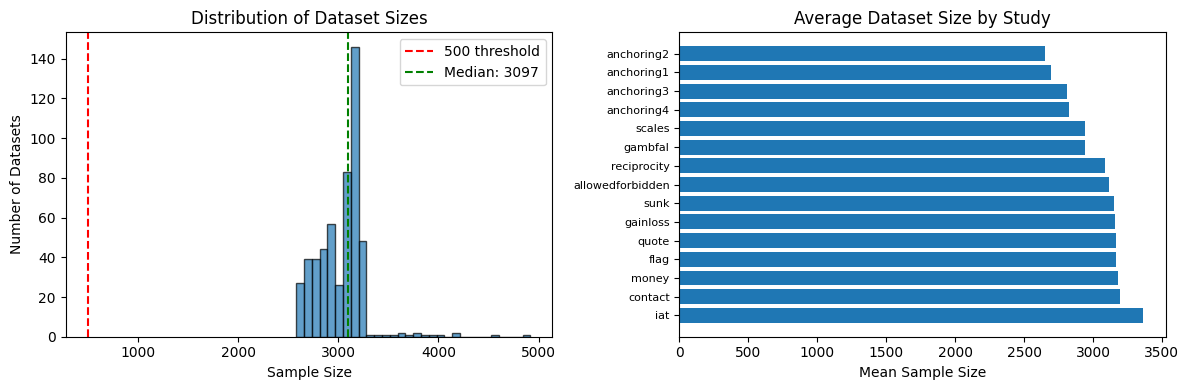

In [20]:
# Sample size visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(sizes_df['n_rows'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=500, color='red', linestyle='--', label='500 threshold')
axes[0].axvline(x=sizes_df['n_rows'].median(), color='green', linestyle='--', 
                label=f'Median: {sizes_df["n_rows"].median():.0f}')
axes[0].set_xlabel('Sample Size')
axes[0].set_ylabel('Number of Datasets')
axes[0].set_title('Distribution of Dataset Sizes')
axes[0].legend()

# By study
study_sizes = sizes_df.groupby('study')['n_rows'].mean().sort_values()
axes[1].barh(range(len(study_sizes)), study_sizes.values)
axes[1].set_yticks(range(len(study_sizes)))
axes[1].set_yticklabels(study_sizes.index, fontsize=8)
axes[1].set_xlabel('Mean Sample Size')
axes[1].set_title('Average Dataset Size by Study')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [21]:
# Final summary
print("\n" + "=" * 60)
print("CONFOUNDED DATASETS SUMMARY")
print("=" * 60)
print(f"\nTotal datasets: {total_files}")
print(f"Total size: {total_size:.1f} MB")
print(f"Studies covered: {len(studies)}")
print(f"Grid coverage: {total_files/expected_total*100:.1f}%")
print(f"Gaps found: {len(gaps)}")
print(f"Sparse datasets (<500): {len(sparse) if 'sparse' in dir() else 'N/A'}")
print(f"Quality issues: {len(quality_issues)}")


CONFOUNDED DATASETS SUMMARY

Total datasets: 525
Total size: 612.9 MB
Studies covered: 15
Grid coverage: 100.0%
Gaps found: 0
Sparse datasets (<500): 0
Quality issues: 15


---
## Next Steps

1. **Method Evaluation**: Use generated datasets to evaluate causal inference methods
2. **Gap Filling**: Regenerate any missing datasets
3. **Quality Fixes**: Address identified quality issues
4. **Documentation**: Document any sparse data periods or known limitations